## Table of Contents <a id = Contents></a>
* [1.0 Preliminary Work](#pre_work)
    * [1.1 Context](#context)
    * [1.2 Key Data Sources](#key-data-sources)
    * [1.3 Problem Statement](#problem-statement)
* [2.0 Exploratory Data Analysis (EDA)](#eda)
    * [2.1 Cleaning](#cleaning)
    * [2.2 Visualize](#vis)
* [Models](#models)
    * []()
***

<h2>1.0 Preliminary Work</h2> <a id = 'pre_work'></a>

***

<h3>1.1 Context</h3> <a id = 'context'></a>

This project attempts to predict CitiBike monthly ridership for NYC via Time Series Analysis. While univariate time series analysis does perform well generally, real-world problems are often more complex and require analyzing contributing factors to forecast appropriately instead of purely based off trend. This project attempts to gather data sources that could correlate with monthly ridership and use a multivariate time series approach to make future predictions.


<h3>1.2 Key Data Sources</h3><a id = key-data-sources></a>

1. [CitiBike Trip Data](https://citibikenyc.com/system-data)

The CitiBike website has the data available for download via Amazon S3 bucket zip files. The following code allows the user to read each zip file directly from the web and retrieve the monthly trip totals.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import re
from io import BytesIO
from zipfile import ZipFile

In [ ]:
data = []
df = pd.DataFrame()
ct = -1


for YY in range(2014,2017):
    for MM in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        
        url_string = f'https://s3.amazonaws.com/tripdata/{YY}{MM}-citibike-tripdata.zip'
        url = urllib.request.urlopen(url_string)
        
        ct = -1
        with ZipFile(BytesIO(url.read())) as my_zip_file:
            for contained_file in my_zip_file.namelist():
                for line in my_zip_file.open(contained_file).readlines():
                    ct+=1
                       
        print(url_string, ct)
        data.append(ct)
        
for YY in range(2017,2023):
    for MM in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        
        url_string = f'https://s3.amazonaws.com/tripdata/{YY}{MM}-citibike-tripdata.csv.zip'
        url = urllib.request.urlopen(url_string)
        
        ct = -1
        with ZipFile(BytesIO(url.read())) as my_zip_file:
            for contained_file in my_zip_file.namelist():
                for line in my_zip_file.open(contained_file).readlines():
                    ct+=1
                       
        print(url_string, ct)
        data.append(ct)

2. [NYC Tourism Report](https://www.osc.state.ny.us/reports/osdc/tourism-industry-new-york-city)
    * [Data](https://data.osc.ny.gov/views/TourismSectorStory/AnVisDB?%3Aembed_code_version=3&%3Aembed=y&%3AloadOrderID=4&%3Adisplay_spinner=no&%3AshowAppBanner=false&%3Atoolbar=no&%3Atabs=no)

The Office of the State Comptroller under partnership with NYC & Company has annual data available via reports. Tourism is broken down into international and domestic with forecasts available for 2022-2023. The data has been compiled manually from these reports and annual data has been used to create monthly average data.

**Note: This is a potential problem as we lose the seasonal decomposition of Tourism in NYC which we know exists. Therefore any correlations are more applicable to the underlying trend when decomposing the time series.**


3. [NYC Population](https://data.census.gov)

Population data was gathered from the United States Census Bureau. 

<h2><span style="color:darkred">1.3 Problem Statement</span></h2><a id = problem-statement></a>

**Can we accurately forecast Citibike ridership for the year? Can we do so in such a way that we can better identify trend derivative changes?**


<h2>2.0 Exploratory Data Analysis (EDA)</h2><a id = eda></a>

***

<h3>2.1 Cleaning</h3> <a id = 'cleaning'></a>

The data has been compiled manually from multiple sources and placed in an excel sheet.

In [56]:
df = pd.read_csv('../../Projects-Data/citibike_ts_data.csv', index_col = 'index', parse_dates=True)


In [57]:
df.head()

,Unnamed: 0,trips,nyc_population,dom_tourism,int_tourism
index,,,,,
2014-01-28,0,300400,8433806.0,44.5,12.0
2014-02-28,1,224736,8433806.0,44.5,12.0
2014-03-28,2,439117,8433806.0,44.5,12.0
2014-04-28,3,670780,8433806.0,44.5,12.0
2014-05-28,4,866117,8433806.0,44.5,12.0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2014-01-28 to 2022-12-28
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      108 non-null    int64  
 1   trips           108 non-null    int64  
 2   nyc_population  96 non-null     float64
 3   dom_tourism     96 non-null     float64
 4   int_tourism     96 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 5.1 KB


In [59]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [60]:
df.head()

,trips,nyc_population,dom_tourism,int_tourism
index,,,,
2014-01-28,300400,8433806.0,44.5,12.0
2014-02-28,224736,8433806.0,44.5,12.0
2014-03-28,439117,8433806.0,44.5,12.0
2014-04-28,670780,8433806.0,44.5,12.0
2014-05-28,866117,8433806.0,44.5,12.0


Tourism and Population are provided annually and I will take an average to get monthly values

In [61]:
df['dom_tourism'] = (df['dom_tourism'] * (10**6)) / 12
df['int_tourism'] = (df['int_tourism'] * (10**6)) / 12
df['nyc_population'] = df['nyc_population'] / 12

In [62]:
df.head()

,trips,nyc_population,dom_tourism,int_tourism
index,,,,
2014-01-28,300400,702817.166667,3.708333e+06,1000000.0
2014-02-28,224736,702817.166667,3.708333e+06,1000000.0
2014-03-28,439117,702817.166667,3.708333e+06,1000000.0
2014-04-28,670780,702817.166667,3.708333e+06,1000000.0
2014-05-28,866117,702817.166667,3.708333e+06,1000000.0


***

<h3>2.2 Visualize </h3> <a id = 'vis'></a>

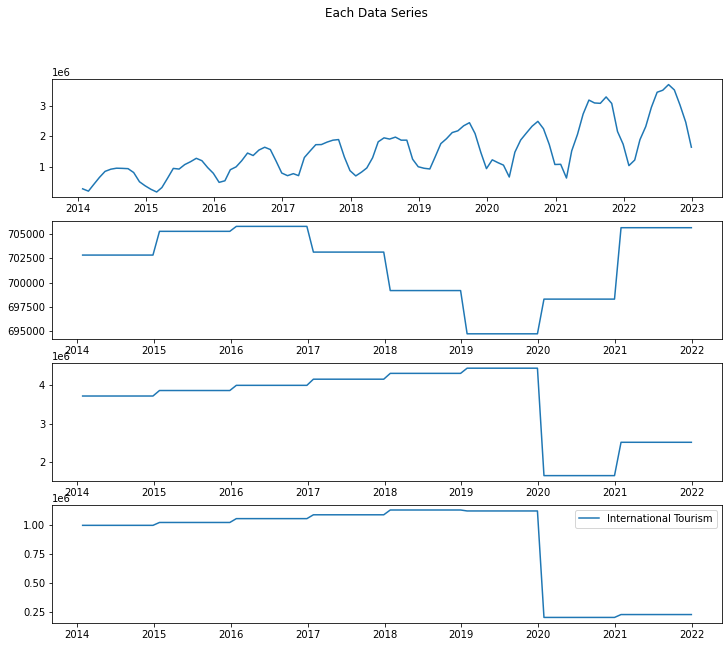

<Figure size 864x720 with 0 Axes>

In [72]:
# 3 subplots
fig, axs = plt.subplots(4,1, figsize=(12,10))
fig.suptitle('Each Data Series')


axs[0].plot(df.index, df.trips, label = "Trips")
axs[1].plot(df.index, df.nyc_population, label = "NYC Pop")
axs[2].plot(df.index, df.dom_tourism, label = "Domestic Tourism")
axs[3].plot(df.index, df.int_tourism, label = "International Tourism")
plt.legend()
plt.show()

In [113]:
# view the trips series in detail 
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 864x720 with 0 Axes>

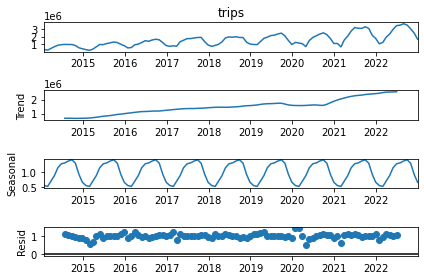

In [121]:
plt.figure(figsize=(12,10))
seasonal_decompose(df.trips, model='multiplicative', period=12).plot()
plt.show()

***

<h3>2.3 Preliminary Analysis and Preprocessing</h3> <a id = 'pre_analysis'></a>

In [81]:
# run the dickey fuller test on each series
from statsmodels.tsa.stattools import adfuller

Split into train and test sets. 2022 data will be used for test set.

In [82]:
train = df[df.index < pd.to_datetime('2022-01-01')]
test = df[~(df.index < pd.to_datetime('2022-01-01'))]

In [95]:
for column in train.columns:
    print("stationarity check for: "+column)
    
    output = adfuller(train[column], autolag = 'AIC') # AIC criterion check
    
    print(f"critical value: {output[0]}")
    print(f"p_value: {output[1]}")
    
    if output[1] < .05:
        print("Stationary\n")
    else:
        print("Not Stationary\n")

stationarity check for: trips
Critical Value: 0.5650389760506017
p_value: 0.9867214384442311
Not Stationary

stationarity check for: nyc_population
Critical Value: -2.3047495806469716
p_value: 0.17044071277830408
Not Stationary

stationarity check for: dom_tourism
Critical Value: -1.3949263305341066
p_value: 0.5847060678316385
Not Stationary

stationarity check for: int_tourism
Critical Value: -0.681250063125674
p_value: 0.8515466024874319
Not Stationary



Normalize the data

In [97]:
from sklearn.preprocessing import StandardScaler

In [103]:
train_ss = pd.DataFrame(StandardScaler().fit_transform(train), index=train.index, columns=[train.columns])

In [104]:
train_ss.head()

,trips,nyc_population,dom_tourism,int_tourism
index,,,,
2014-01-28,-1.542596,0.25644,0.150111,0.380804
2014-02-28,-1.649657,0.25644,0.150111,0.380804
2014-03-28,-1.346316,0.25644,0.150111,0.380804
2014-04-28,-1.018522,0.25644,0.150111,0.380804
2014-05-28,-0.742127,0.25644,0.150111,0.380804


Visualize scaled time series

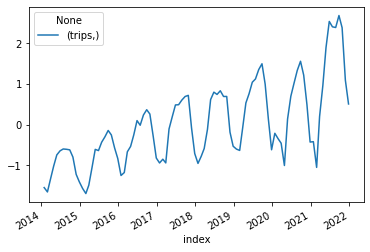

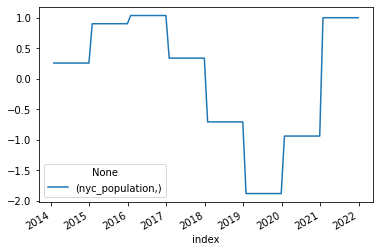

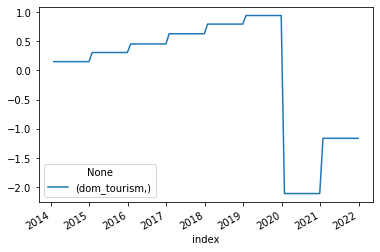

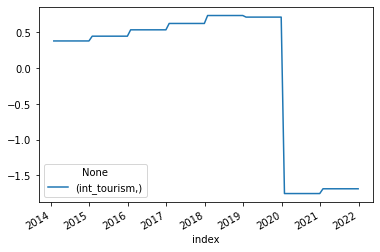

In [111]:
for column in train_ss.columns:
    train_ss.plot(y=column)
    plt.show()

Take the difference to get a stationary time series

In [122]:
train_ss_diff1 = train_ss.diff().dropna()

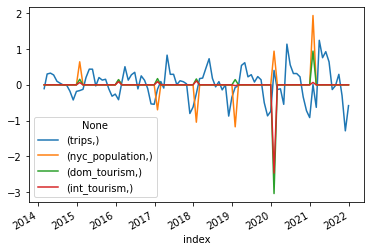

In [124]:
train_ss_diff1.plot()
plt.show()

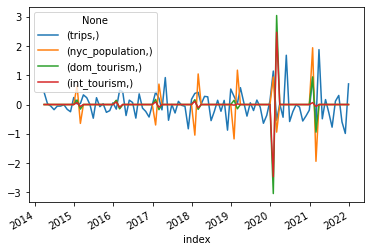

In [125]:
train_ss_diff2 = train_ss_diff1.diff().dropna()
train_ss_diff2.plot()
plt.show()

test stationarity again

In [143]:
train_ss_diff2

,trips,nyc_population,dom_tourism,int_tourism
index,,,,
2014-03-28,0.410403,0.0,0.0,0.0
2014-04-28,0.024453,0.0,0.0,0.0
2014-05-28,-0.051400,0.0,0.0,0.0
2014-06-28,-0.176268,0.0,0.0,0.0
2014-07-28,-0.054902,0.0,0.0,0.0
...,...,...,...,...
2021-08-28,0.114734,0.0,0.0,0.0
2021-09-28,0.311020,0.0,0.0,0.0
2021-10-28,-0.592943,0.0,0.0,0.0


In [149]:
train_ss_diff2.columns = train.columns

for column in train_ss_diff1.columns:
    print("stationarity check for: "+column)
    
    output = adfuller(train_ss_diff1[column], autolag = 'AIC') # AIC criterion check
    
    print(f"critical value: {output[0]}")
    print(f"p_value: {output[1]}")
    
    if output[1] < .05:
        print("Stationary\n")
    else:
        print("Not Stationary\n")

stationarity check for: trips
critical value: -8.218491593326183
p_value: 6.525635865385327e-13
Stationary

stationarity check for: nyc_population
critical value: -9.598682265555556
p_value: 1.9469313826833368e-16
Stationary

stationarity check for: dom_tourism
critical value: -9.608767322228868
p_value: 1.8356468093258593e-16
Stationary

stationarity check for: int_tourism
critical value: -9.663654935933337
p_value: 1.3328547574100916e-16
Stationary



The series are now stationary

<h2>3.0 Models </h2><a id = models></a>

***

Split into train and test sets. 2022 data will be used for test set.

In [151]:
train_ss_diff1.head()

,trips,nyc_population,dom_tourism,int_tourism
index,,,,
2014-02-28,-0.107062,0.0,0.0,0.0
2014-03-28,0.303341,0.0,0.0,0.0
2014-04-28,0.327794,0.0,0.0,0.0
2014-05-28,0.276394,0.0,0.0,0.0
2014-06-28,0.100127,0.0,0.0,0.0


In [152]:
test.head()

,trips,nyc_population,dom_tourism,int_tourism
index,,,,
2022-01-28,1052419,NaN,NaN,NaN
2022-02-28,1233715,NaN,NaN,NaN
2022-03-28,1893445,NaN,NaN,NaN
2022-04-28,2319614,NaN,NaN,NaN
2022-05-28,2940601,NaN,NaN,NaN


The trip data for the test set is present while the other features do not have the values for testing.

In [157]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

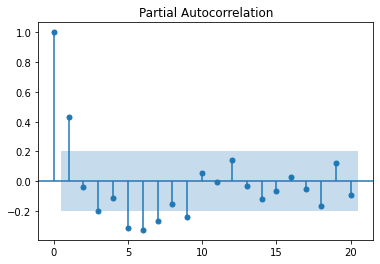

In [159]:
plot_pacf(train_ss_diff1['trips'], method='ywm')
plt.show()

Here it shows the first 2 terms have significance

In [164]:
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

In [167]:
results = []
for lag in range(1, 16):
    trips_vector = train_ss_diff1['trips'].iloc[lag:]
    lagged_vector = train_ss_diff1['nyc_population'].iloc[:-lag]

    result = pearsonr(trips_vector, lagged_vector)
    result = [round(x, 4) for x in result]
   
    results.append({'lag': lag,
                        'pearson correlation': result[0],
                        'p-value': result[1]})
    
results = pd.DataFrame(results)
results

,lag,pearson correlation,p-value
0,1,-0.1344,0.1964
1,2,0.1415,0.1761
2,3,-0.0453,0.6683
3,4,0.1607,0.1282
4,5,0.0873,0.4130
5,6,0.0092,0.9320
6,7,-0.0058,0.9573
7,8,0.0666,0.5399
8,9,-0.0355,0.7459
9,10,-0.0810,0.4611


In [168]:
results = []
for lag in range(1, 16):
    trips_vector = train_ss_diff1['trips'].iloc[lag:]
    lagged_vector = train_ss_diff1['dom_tourism'].iloc[:-lag]

    result = pearsonr(trips_vector, lagged_vector)
    result = [round(x, 4) for x in result]
   
    results.append({'lag': lag,
                        'pearson correlation': result[0],
                        'p-value': result[1]})
    
results = pd.DataFrame(results)
results

,lag,pearson correlation,p-value
0,1,-0.0094,0.9283
1,2,0.1264,0.2274
2,3,0.2036,0.0516
3,4,-0.1645,0.1193
4,5,-0.0660,0.5368
5,6,-0.0767,0.4751
6,7,-0.0610,0.5725
7,8,-0.0243,0.8236
8,9,0.0487,0.6562
9,10,0.0350,0.7505


In [170]:
results = []
for lag in range(1, 16):
    trips_vector = train_ss_diff1['trips'].iloc[lag:]
    lagged_vector = train_ss_diff1['int_tourism'].iloc[:-lag]

    result = pearsonr(trips_vector, lagged_vector)
    result = [round(x, 4) for x in result]
   
    results.append({'lag': lag,
                        'pearson correlation': result[0],
                        'p-value': result[1]})
    
results = pd.DataFrame(results)
results

,lag,pearson correlation,p-value
0,1,0.0338,0.7466
1,2,0.0431,0.6815
2,3,0.1497,0.1544
3,4,-0.2427,0.0205
4,5,-0.1172,0.2711
5,6,-0.0727,0.4986
6,7,-0.0672,0.5338
7,8,-0.0471,0.6652
8,9,0.0800,0.4641
9,10,0.1455,0.1841


The model to use looks like LAG 4 For Domestic Tourism, LAG 14 for International Tourism, and nothing for population.

In [171]:
# modeling
model = VAR(train_ss_diff1)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [185]:
results = model.fit(maxlags=15, ic='aic') # 3-4 max

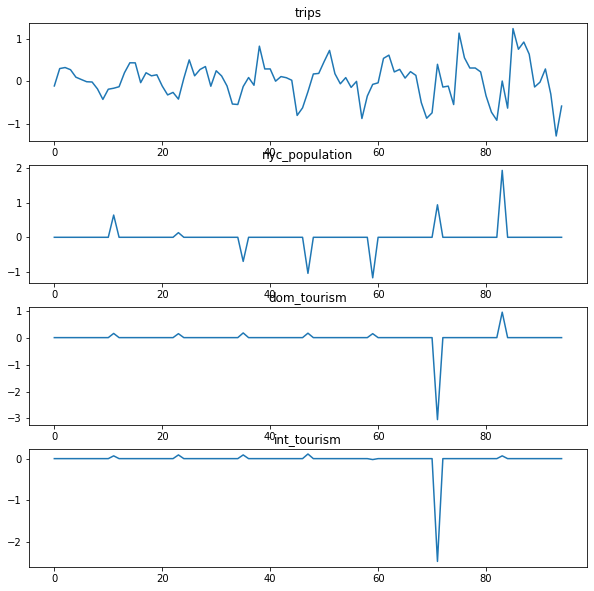

In [186]:
results.plot()
plt.show()

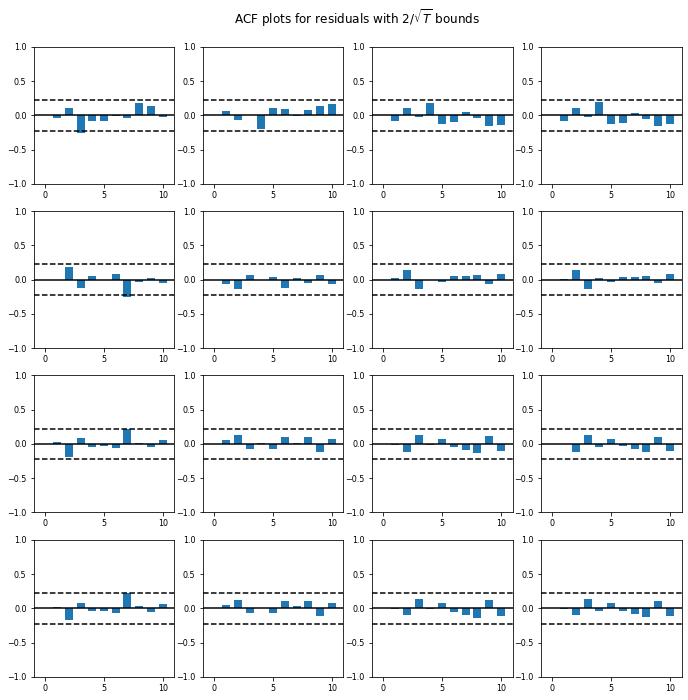

In [187]:
results.plot_acorr()
plt.show()

In [188]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, Apr, 2023
Time:                     15:53:45
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -12.7603
Nobs:                     80.0000    HQIC:                  -17.1126
Log likelihood:           590.957    FPE:                1.36688e-08
AIC:                     -20.0254    Det(Omega_mle):     1.41649e-09
--------------------------------------------------------------------
Results for equation trips
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.172315         0.094610            1.821           0.069
L1.trips                  -0.233981         0.228376           -1.025           0.306
L1.nyc_population          0.070401     

In [189]:
lag_order = results.k_ar

In [190]:
results.k_ar

15

In [191]:
results.forecast(train_ss_diff1.values[-lag_order:],12)

array([[ -1.19311218,   9.47994509, -11.61561049,  -8.87706021],
       [ -0.38242538,   0.65705225,   0.97395879,   0.89193295],
       [  1.23276393,  -1.73679604,   1.45906007,   1.07710724],
       [ -2.99109175,   1.84468879,  -2.65725863,  -2.04729561],
       [  1.61783793,   1.30060411,  -0.96328945,  -0.61748882],
       [  0.74669724,   0.38311049,   0.18820455,   0.18556298],
       [  0.40312022,  -2.05343691,   1.24780287,   0.95966037],
       [  0.67118088,   0.22816029,  -1.34860298,  -1.18155671],
       [ -0.45213562,   0.7762601 ,  -0.79483821,  -0.55286595],
       [  0.14762242,   1.49210806,  -0.91978197,  -0.60060189],
       [  1.8491619 ,  -1.72092813,   2.19264455,   1.65003897],
       [ -1.63296976,  -1.33842646,   1.02997168,   0.69806401]])

TypeError: predict() missing 1 required positional argument: 'params'